# PM2.5 Forecasting in Beijing

## By Teny Makuach

### Project Overview
This project focuses on forecasting air quality in Beijing by predicting PM2.5 concentrations, a critical air pollutant with a diameter of less than 2.5 micrometers. PM2.5 poses significant health risks, particularly in urban areas, due to its ability to penetrate deep into the respiratory system.

Leveraging historical data, this project employs advanced time series modeling using Long Short-Term Memory (LSTM) networks to capture temporal dependencies and patterns in the data. The dataset comprises hourly PM2.5 measurements along with features such as No, DEWP (Dew Point), TEMP (Temperature), PRES (Pressure), Iws (Cumulated Wind Speed), Is (Cumulated Hours of Snow), Ir (Cumulated Hours of Rain), datetime, cbwd_NW (Northwest Wind), cbwd_SE (Southeast Wind), cbwd_cv (Calm/Variable Wind). These features are used to train the model to accurately predict future PM2.5 levels.


I first handled missing values by filling them with the mean of their respective columns. Then, I performed feature engineering by creating new features such as hour, day of the week, and their cyclical transformations (sine and cosine) to capture periodic patterns. Additionally, I scaled the features using MinMaxScaler to normalize the data for better model performance. Finally, I prepared the data for time series modeling by creating lagged features, rolling statistics, and sequences to capture temporal dependencies effectively.

I implemented a multivariate time series forecast to capture all the necessary informations and patterns that may influence PM2.5 levels, making it a multivariate time series forecasting problem.
### Goal
The primary objective is to develop a robust forecasting tool for PM2.5 concentrations. This tool aims to provide early warnings about deteriorating air quality, enabling residents to take precautionary measures. Additionally, it supports policymakers in crafting proactive environmental and public health strategies to mitigate the impact of air pollution.


# Project Structure

1. **Introduction**  
    - Overview of the project and its objectives.
    - Importance of forecasting PM2.5 levels for public health and policymaking.

2. **Data Preparation**  
    - Loading and exploring the dataset.
    - Handling missing values.
    - Feature engineering (e.g., creating cyclical features, lagged features, rolling statistics).

3. **Data Preprocessing**  
    - Scaling features using MinMaxScaler.
    - Creating sequences for time series modeling.

4. **Model Development**  
    - Building and compiling the LSTM model.
    - Experimenting with hyperparameters and architecture.

5. **Model Training**  
    - Training the model with early stopping and learning rate reduction.
    - Evaluating training and validation loss.

6. **Prediction and Submission**  
    - Preparing test data for predictions.
    - Generating predictions for PM2.5 levels.
    - Creating and saving the submission file.

7. **Visualization and Analysis**  
    - Visualizing training loss and target variable distribution.
    - Analyzing model performance and results.


## Dataset Overview

This dataset contains historical air quality and meteorological data collected in Beijing. It is used to develop a time series forecasting model to predict PM2.5 concentrations.

### **Features Description**

| Column Name   | Description |
|---------------|-------------|
| `No`          | Row index or observation number (not essential for modeling) |
| `DEWP`        | Dew Point (°C) – represents atmospheric moisture |
| `TEMP`        | Temperature (°C) |
| `PRES`        | Atmospheric Pressure (hPa) |
| `Iws`         | Cumulative Wind Speed (m/s) |
| `Is`          | Cumulative hours of snow |
| `Ir`          | Cumulative hours of rain |
| `datetime`    | Timestamp of observation (used for time-based feature engineering) |
| `cbwd_NW`     | Binary indicator for wind coming from the northwest (one-hot encoded) |
| `cbwd_SE`     | Binary indicator for wind coming from the southeast (one-hot encoded) |
| `cbwd_cv`     | Binary indicator for calm or variable wind direction (one-hot encoded) |

> 🔍 **Note:** The `PM2.5` column is the target variable for prediction. 


### **Data Characteristics**
- **Timeframe:** Hourly data
- **Location:** Beijing, China
- **Data Type:** Numerical, categorical, and temporal
- **Usage:** Supervised time series regression task



## Import packages

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Bidirectional, BatchNormalization


/Users/makuachtenygatluak/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('../time_series/train.csv')
test = pd.read_csv('../time_series/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [3]:
# Inspecting the first few rows of the dataset to understand its structure.

# Display the shape of the datasets
print("Train Data Shape:", train.shape)

# Display the information about the datasets
print("Train Data Info:")
train.info()

print("Training Data Overview:")
train.head()

Train Data Shape: (30676, 12)
Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB
Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [4]:
# compare the columns of training and testing datasets
print("Training Data columns:")
train.columns
print("Testing Data columns:")  
test.columns

# compare in order to prepare the data and test for training
print("Columns in train but not in test:")
print(set(train.columns) - set(test.columns))

print("Columns in test but not in train:")
print(set(test.columns) - set(train.columns))

Training Data columns:
Testing Data columns:
Columns in train but not in test:
{'pm2.5'}
Columns in test but not in train:
set()


In [5]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


# Handle missing values


- Check the dataset for missing values and decide how to handle them.
- In this example, missing values are filled with the mean. You can experiment with other strategies.

In [6]:
train.fillna(train.mean(numeric_only=True), inplace=True)
test.fillna(test.mean(numeric_only=True), inplace=True)
print(train.head())

                     No      DEWP      TEMP      PRES       Iws        Is  \
datetime                                                                    
2010-01-01 00:00:00   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353   
2010-01-01 01:00:00   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353   
2010-01-01 02:00:00   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353   
2010-01-01 03:00:00   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353   
2010-01-01 04:00:00   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353   

                           Ir   cbwd_NW   cbwd_SE   cbwd_cv       pm2.5  
datetime                                                                 
2010-01-01 00:00:00 -0.137667  1.448138 -0.732019 -0.522096  100.793427  
2010-01-01 01:00:00 -0.137667  1.448138 -0.732019 -0.522096  100.793427  
2010-01-01 02:00:00 -0.137667  1.448138 -0.732019 -0.522096  100.793427  
2010-01-01 03:00:00 -0.137667  1.448138 -0.732019 -0.522096  100.793427  
2010-01-01 04:00

In [7]:
# Features engineering
# Create new features based on the datetime index
for df in [train, test]:
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    # cyclical features for hour and day of week to ensure that the model can 
    # learn the periodic nature of these features.
    df['hour_sin'] = np.sin(df['hour'] * (2. * np.pi / 24))
    df['hour_cos'] = np.cos(df['hour'] * (2. * np.pi / 24))
    df['dayofweek_sin'] = np.sin(df['dayofweek'] * (2. * np.pi / 7))
    df['dayofweek_cos'] = np.cos(df['dayofweek'] * (2. * np.pi / 7))

print(train.columns)
print(train.head())

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'cbwd_NW', 'cbwd_SE',
       'cbwd_cv', 'pm2.5', 'hour', 'dayofweek', 'hour_sin', 'hour_cos',
       'dayofweek_sin', 'dayofweek_cos'],
      dtype='object')
                     No      DEWP      TEMP      PRES       Iws        Is  \
datetime                                                                    
2010-01-01 00:00:00   1 -1.580878 -1.922250  0.443328 -0.441894 -0.069353   
2010-01-01 01:00:00   2 -1.580878 -2.004228  0.345943 -0.379306 -0.069353   
2010-01-01 02:00:00   3 -1.580878 -1.922250  0.248559 -0.343514 -0.069353   
2010-01-01 03:00:00   4 -1.580878 -2.168183  0.248559 -0.280926 -0.069353   
2010-01-01 04:00:00   5 -1.511594 -2.004228  0.151174 -0.218339 -0.069353   

                           Ir   cbwd_NW   cbwd_SE   cbwd_cv       pm2.5  hour  \
datetime                                                                        
2010-01-01 00:00:00 -0.137667  1.448138 -0.732019 -0.522096  100.793427     0   
201

In [8]:
# # create lagged features for pm2.5 in the training set and test set
# for lag in range(1, 4):
#     train[f'pm2.5_lagged_{lag}'] = train['pm2.5'].shift(lag)
    
# # add lagged features to the test set
# for lag in range(1, 4):
#     test[f'pm2.5_lagged_{lag}'] = test['pm2.5'].shift(lag)

# print(train.head())

In [9]:
# # Add rolling statistics features whcich helps the model focus on long-term trends
# # and gives the model gives information about how stable the data is over time.
# # it also enriches features by adding derived fetures that improve the model's 
# # ability to learn.
# train['pm2.5_rolling_mean'] = train['pm2.5'].rolling(window=3).mean()
# train['pm2.5_rolling_std'] = train['pm2.5'].rolling(window=3).std()

# # add rolling statistics features to the test set
# test['pm2.5_rolling_mean'] = test['pm2.5'].rolling(window=3).mean()
# test['pm2.5_rolling_std'] = test['pm2.5'].rolling(window=3).std()
# # Drop rows with NaN values created by lagging and rolling operations

# Separate features and target

- Feel free to drop any non-essential columns like that you think might not contribute to modeling.

In [10]:
# Drop rows with NaN values created by lagging and rolling operations  
train.dropna(inplace=True)
X_train = train.drop(['pm2.5', 'No', 'hour', 'dayofweek'], axis=1)
y_train = train['pm2.5']

# Drop the same columns in the test set
test.drop(['No', 'hour', 'dayofweek'], axis=1, inplace=True)

# test.dropna(inplace=True)
# print(X_train.columns)
# print(test.columns)
# print(y_train.head())

# Check that the columns in train and test datasets match
print("Columns in test but not in train:")
print(set(test.columns) - set(X_train.columns))

# ensure that there is no missing values in the training set
print(X_train.isnull().sum())

Columns in test but not in train:
set()
DEWP             0
TEMP             0
PRES             0
Iws              0
Is               0
Ir               0
cbwd_NW          0
cbwd_SE          0
cbwd_cv          0
hour_sin         0
hour_cos         0
dayofweek_sin    0
dayofweek_cos    0
dtype: int64


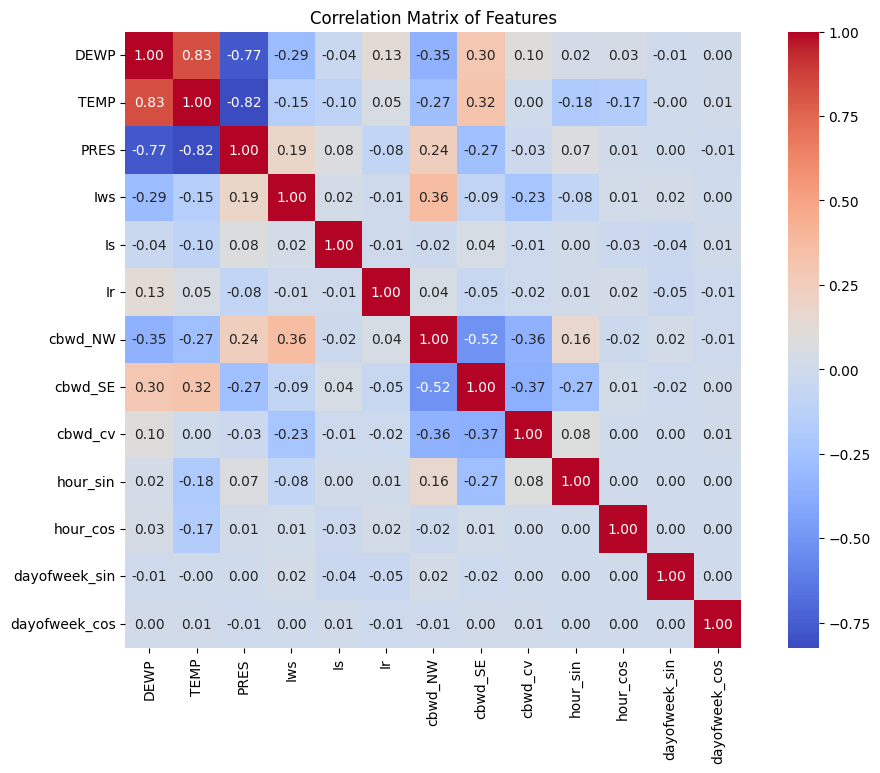

Correlation with target variable (pm2.5):
DEWP             0.211222
cbwd_cv          0.152798
cbwd_SE          0.115238
hour_cos         0.082409
Is               0.022274
hour_sin         0.018976
dayofweek_cos    0.008209
dayofweek_sin   -0.004900
TEMP            -0.038277
Ir              -0.051109
PRES            -0.104931
cbwd_NW         -0.223920
Iws             -0.249722
dtype: float64
Remaining features after dropping low correlation features:
['DEWP', 'PRES', 'Iws', 'cbwd_NW', 'cbwd_SE', 'cbwd_cv']


In [11]:
# Confusion matrix to check the correlation between features
plt.figure(figsize=(12, 8))
sns.heatmap(X_train.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Features')
plt.show()
# Calculate correlation in respect to the target variable
correlation = X_train.corrwith(y_train).sort_values(ascending=False)
# Print the correlation values
print("Correlation with target variable (pm2.5):")
print(correlation)

# Drop features with low correlation to the target variable
low_correlation_threshold = 0.1
low_correlation_features = correlation[abs(correlation) < low_correlation_threshold].index.tolist()
# Drop low correlation features from the training set
X_train.drop(columns=low_correlation_features, inplace=True)
# Drop low correlation features from the test set
test.drop(columns=low_correlation_features, inplace=True)
# Print the remaining features after dropping low correlation features
print("Remaining features after dropping low correlation features:")
print(X_train.columns.tolist())


In [12]:
# For input features
X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)

# For the target
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))


In [13]:
# Convert data into sequences using the sliding window approach
# This ensures that the model learns from the past data to predict the future
def create_seq(data, target, window):
    X_sequence = []
    y_sequence = []
    # Iterate over the data to create sequences of the specified window size
    # by sliding the window over the data
    for i in range(len(data) - window):
        # Extracting the sequence of features and the target variable
        # for the current window
        X_sequence.append(data[i:i + window])
        y_sequence.append(target[i + window])
    return np.array(X_sequence), np.array(y_sequence)

# Create the sequences over the window of 24 hours
X_seq, y_seq = create_seq(X_train_scaled, y_train_scaled, window=24)

print(X_seq.shape)
print(y_seq.shape)

(30652, 24, 6)
(30652, 1)


In [14]:
# Reshape data for LSTM input
# LSTM models require data in the shape (samples, timesteps, features).
# Here, the data is reshaped to add a "timesteps" dimension.
X_seq = X_seq.reshape(X_seq.shape[0], X_seq.shape[1], X_seq.shape[2])

# Build model

Below is a simple LSTM model. Your task is to experiment with different parameters like, numbers of layers, units, activation functions, and optimizers, etc to get the best performing model. Experiment with other optimizers (e.g., SGD) or hyperparameters to improve performance.

In [15]:
# define model
model = Sequential([
    # This layer processes the input data and learns to extract low level features
    # from the input sequences.
    Input(shape=(X_seq.shape[1], X_seq.shape[2])),
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))),
    # stabilizes the output of the previous layer by normalizing it.
    BatchNormalization(), 
    Dropout(0.3),
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))), 
    BatchNormalization(),
    Dropout(0.3),
    Dense(1),
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')]
)

# Display the model architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 24, 128)        │        36,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,401 (306.25 KB)

 Trainable params: 78,017 (304.75 KB)

 Non-trainable params: 384 (1.50 KB)

In [16]:
# Train the model
# You can adjust the number of epochs and batch size to improve performance.
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1
)
history = model.fit(
    X_seq, y_seq,
    epochs=10,
    #validation split is used to evaluate the model's performance on unseen data
    validation_split=0.2,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - loss: 0.8880 - rmse: 0.7695 - val_loss: 0.1902 - val_rmse: 0.0966 - learning_rate: 0.0010
Epoch 2/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.1727 - rmse: 0.1212 - val_loss: 0.1084 - val_rmse: 0.0928 - learning_rate: 0.0010
Epoch 3/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0918 - rmse: 0.0759 - val_loss: 0.0608 - val_rmse: 0.0922 - learning_rate: 0.0010
Epoch 4/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0503 - rmse: 0.0757 - val_loss: 0.0343 - val_rmse: 0.0910 - learning_rate: 0.0010
Epoch 5/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0277 - rmse: 0.0762 - val_loss: 0.0209 - val_rmse: 0.0923 - learning_rate: 0.0010
Epoch 6/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step - loss: 0.0163 - rmse: 0.0773 - val_loss: 0.0139 - val_rmse: 0.0908 - learning_rate: 0.0010
Epoch 7/10
767/767 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0104 - rmse: 0.0752 - val_loss: 0.0114 - val_rmse: 0.0938 - 

958/958 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


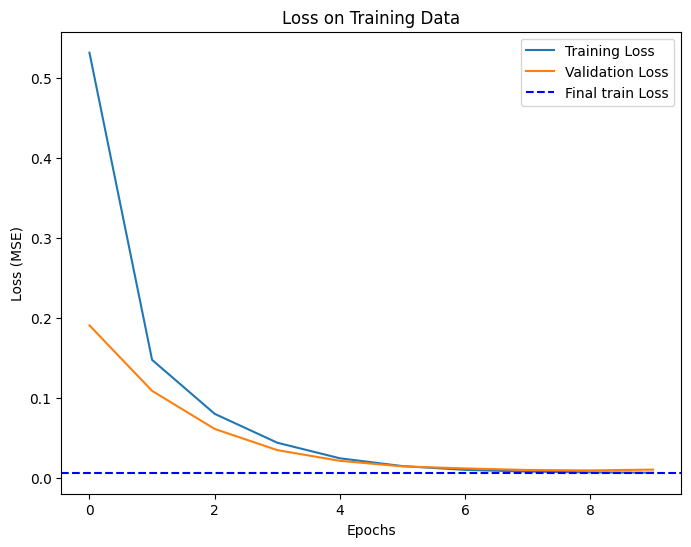

Final Training Loss (MSE): 0.005737105528806852


In [17]:
# Calculate training loss
train_predictions = model.predict(X_seq)

train_loss = np.mean((y_seq.flatten() - train_predictions.flatten())**2)

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # Validation loss during epochs
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")

In [18]:
# Prepare the test data
# Reshape test data to match the input shape expected by the model
X_test = test.values.reshape(test.shape[0], 1, test.shape[1])

# Make predictions on the test set using trained model to predict "pm2.5" concentrations
predictions = model.predict(X_test)

predictions = y_scaler.inverse_transform(predictions) 

# Ensure predictions do not contain NaN values
predictions = np.nan_to_num(predictions)

# Convert predictions to integers
predictions = np.round(predictions).astype(int)
print("Length of test.index:", len(test.index))
print("Length of predictions:", len(predictions))
# Prepare the submission file
# Convert 'row ID' index to string and remove leading zeros for single-digit hours
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

# Sort the submission by 'row ID' to match the solution file exactly
submission = submission.sort_values(by='row ID')

# Save the file in CSV format for submission on Kaggle
submission.to_csv('../time_series/subm_fixed.csv', index=False)

411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 431us/step
Length of test.index: 13148
Length of predictions: 13148


[[124]
 [123]
 [124]
 [123]
 [123]
 [123]
 [121]
 [121]
 [119]
 [119]]


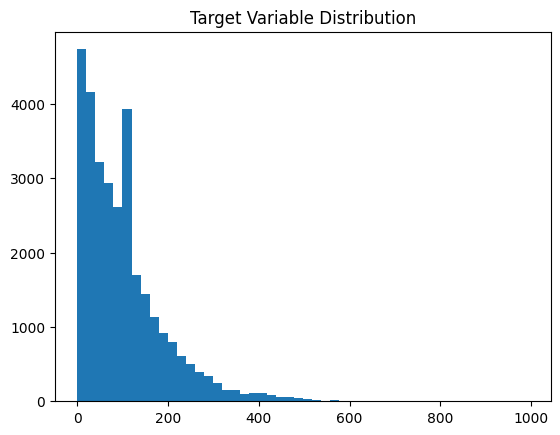

In [19]:
print(predictions[:10])  # Inspect the first few predictions
import matplotlib.pyplot as plt
plt.hist(y_train, bins=50)
plt.title("Target Variable Distribution")
plt.show()